In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy import stats
from scipy.signal import get_window
import glob
import time
def rffts(ys): #the imput are 2d arrays bc this function computes multiple ffts
    Ys = fft.rfft(ys, axis = 1) 
    
    return Ys


def filtering_func(freqs, fft, f1, f2):
    filtered_fft = fft.copy() #in this way it doesn't reference to fft

    fft_in_range = fft[(freqs >= f1) & (freqs <= f2)]
    print(f'fft_in_range: {fft_in_range} ')

    range_avg = np.mean(fft_in_range)
    print(f'range_avg: {range_avg}')
    peak = np.max(fft_in_range)

    peak_indices = np.where(fft_in_range == peak)[0]
    peak_f = freqs[(freqs >= f1) & (freqs <= f2)][peak_indices]
    print(f"peak_f: {peak_f}")

    print(f'sum: {np.sum(np.isin(freqs, peak_f))}')
    filtered_fft[np.isin(freqs, peak_f)] = range_avg
    return filtered_fft

In [2]:
hour = '15.42'
day = '08082024'

In [3]:
file_pattern = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list = []


if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list.append(amplitudes)
        
all_amplitudes = np.stack(amplitudes_list, axis = 0)
N = len(times)
print(f"len(times): {N}")

0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
62500    49.99920067
62501    50.00000067
62502    50.00080067
62503    50.00160067
62504    50.00240067
Name: Time, Length: 62505, dtype: object
0               (mV)
1        -1.96850400
2        -1.57480300
3        -1.18110200
4        -0.78740150
            ...     
62500     0.00000000
62501     0.39370070
62502    -0.39370070
62503    -1.18110200
62504    -1.18110200
Name: Channel D, Length: 62505, dtype: object
len(times): 62504


## FFT

In [4]:
span = times[-1]
print(f"span: {span}") 
f_s = len(times) / span
print(f"f_s = {f_s}")
freqs = fft.rfftfreq(all_amplitudes.shape[1], 1/f_s) #window lenght, sample spacing
print(freqs[-1]) ##this should be the half of f_s.

print(f"len(freqs): {len(freqs)}")
Ys = np.abs(rffts(all_amplitudes))
avg_fft = np.mean(Ys, axis = 0) 
n = np.max(avg_fft)
avg_fft_au = avg_fft / n

span: 50.00240067
f_s = 1250.0199822905822
625.0099911452911
len(freqs): 31253


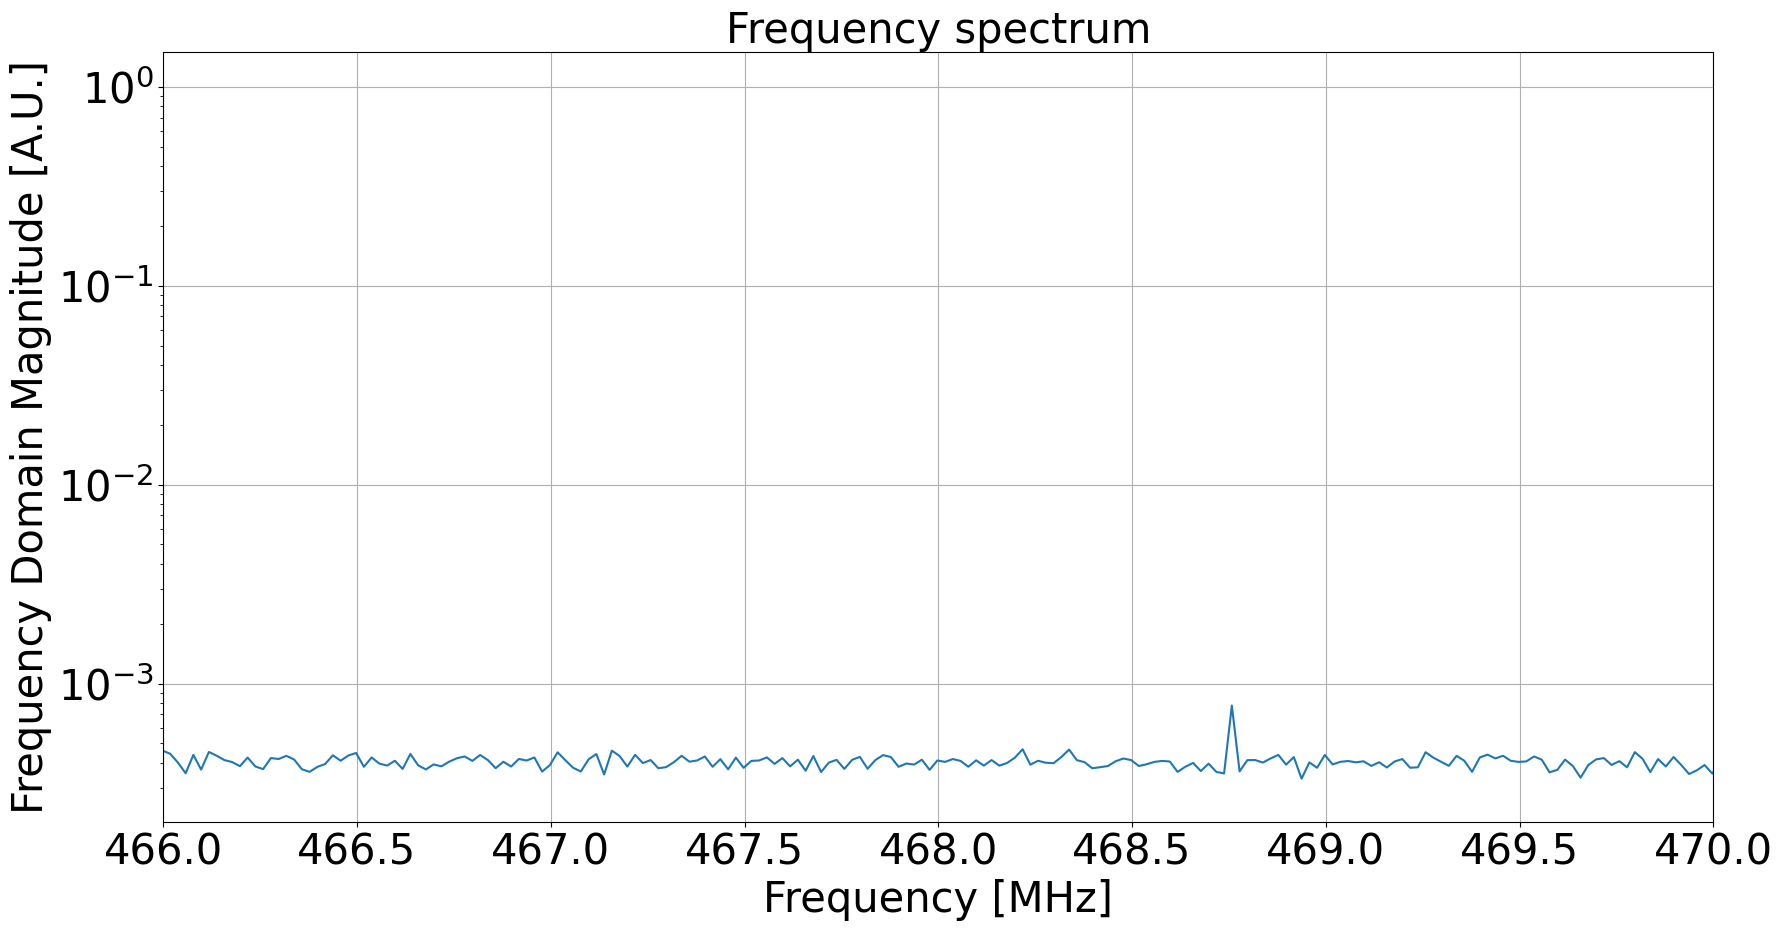

In [59]:
f1 = 466
f2 = 470

plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs, avg_fft_au)

plt.axvline(465.97762683, color = 'red', alpha = 0.2)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.semilogy()
plt.grid(True)
plt.xlim(f1, f2)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

## Filtering

In [60]:
filtered_fft = filtering_func(freqs, avg_fft_au, f1, f2)

fft_in_range: [0.00044355 0.00040067 0.00035403 0.00043783 0.00036922 0.00045291
 0.00043363 0.00041221 0.000403   0.0003842  0.00042436 0.00038285
 0.00037132 0.00042198 0.00041753 0.00043304 0.00041493 0.00037077
 0.00035985 0.00038105 0.00039395 0.0004359  0.00040916 0.00043495
 0.00044753 0.00038148 0.00042492 0.00039571 0.00038685 0.00040902
 0.00037212 0.00044254 0.0003882  0.00036993 0.00039218 0.00038353
 0.00040463 0.00042103 0.00042996 0.00040845 0.00043733 0.00041237
 0.00037538 0.00040441 0.00038268 0.00041757 0.00041018 0.00042488
 0.00036088 0.00038902 0.0004511  0.00041156 0.0003772  0.00036118
 0.0004162  0.00044221 0.00034896 0.00045984 0.00043206 0.0003824
 0.00043821 0.00039817 0.00041245 0.00037517 0.00037991 0.00040232
 0.00043318 0.00040469 0.00041043 0.00043009 0.00038157 0.00041672
 0.00037059 0.00042421 0.00037702 0.00040838 0.00041032 0.00042529
 0.00039451 0.00042192 0.00038326 0.00041422 0.00036454 0.00043203
 0.0003589  0.00040057 0.00041344 0.00037213 0.00

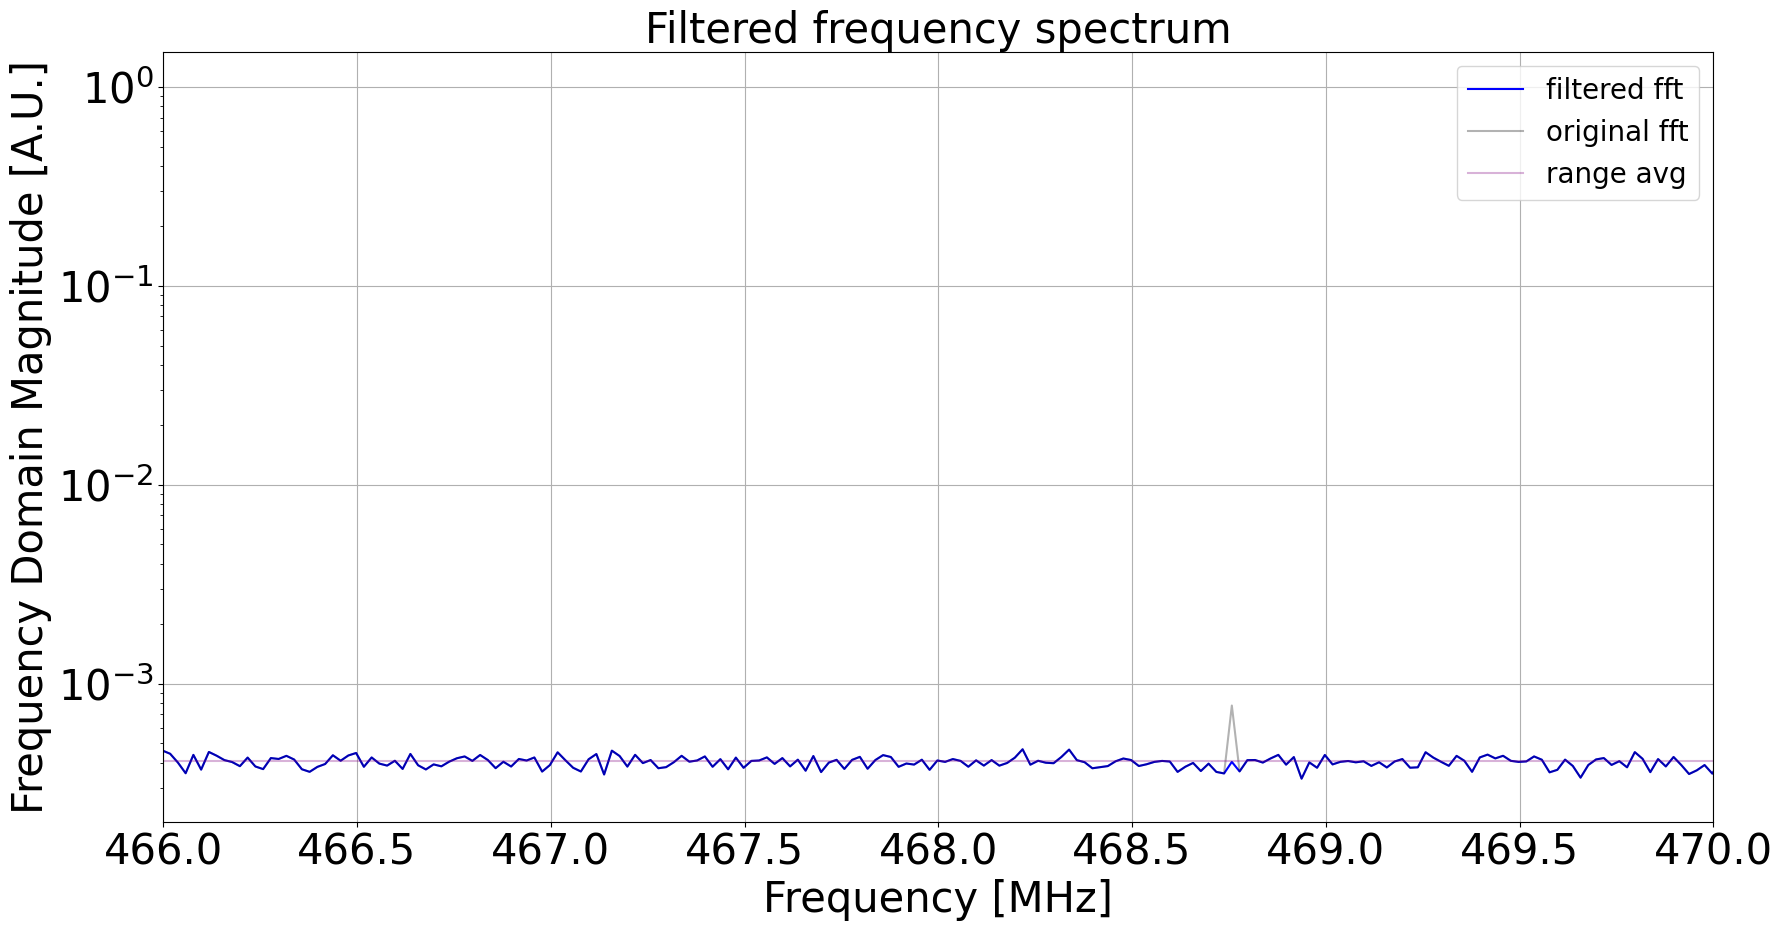

In [61]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs, filtered_fft, color = 'blue', label = 'filtered fft')
plt.plot(freqs, avg_fft_au, alpha = 0.3, color = 'k', label = 'original fft')
plt.axhline( 0.0004081262997163187, color = 'purple', alpha = 0.3, label = 'range avg')

#plt.axvline(465.97762683, color = 'red')
plt.title('Filtered frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.semilogy()

plt.xlim(f1, f2)
plt.legend(loc = 'best', fontsize = 20)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

## IFFT

In [62]:
times_ifft = np.arange(N) / f_s 
amplitudes_ifft = fft.irfft(filtered_fft)


## Compare to average waveform

In [63]:
original_wf = fft.irfft(avg_fft_au)

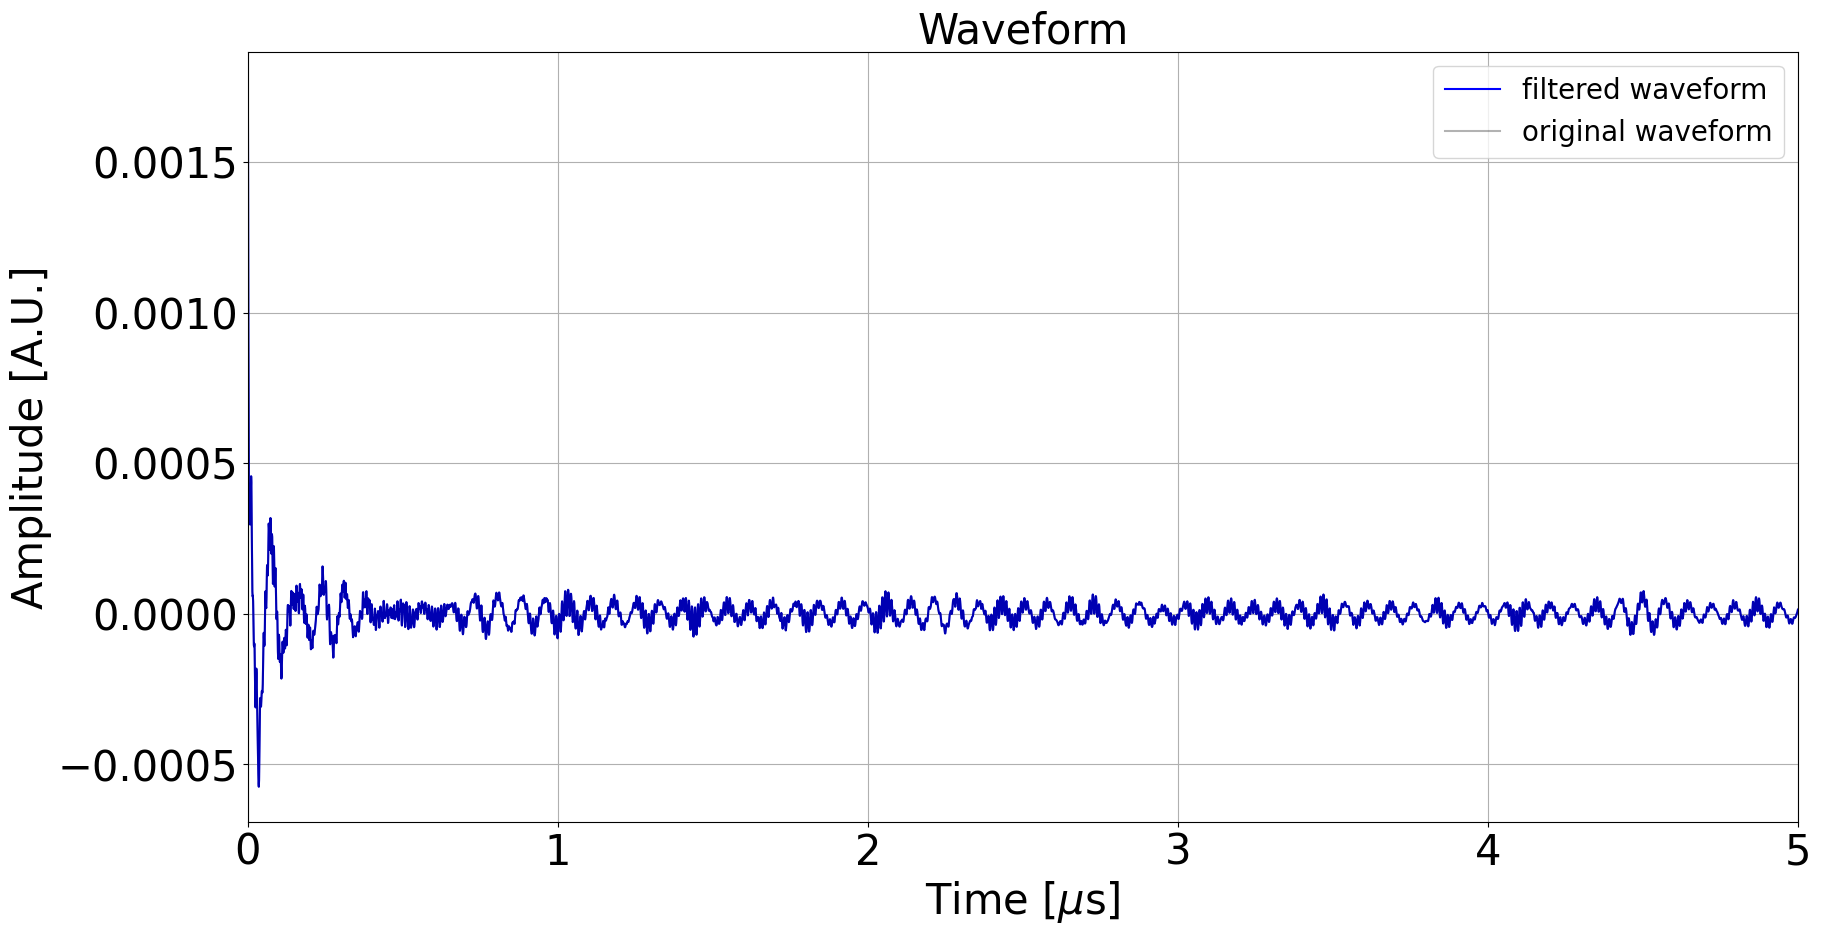

In [64]:
plt.figure(figsize = (20, 10))
plt.plot(times_ifft, amplitudes_ifft, label = 'filtered waveform', color = 'blue')
plt.plot(times_ifft, original_wf, label = 'original waveform', color = 'k', alpha = 0.3)
plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 5)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

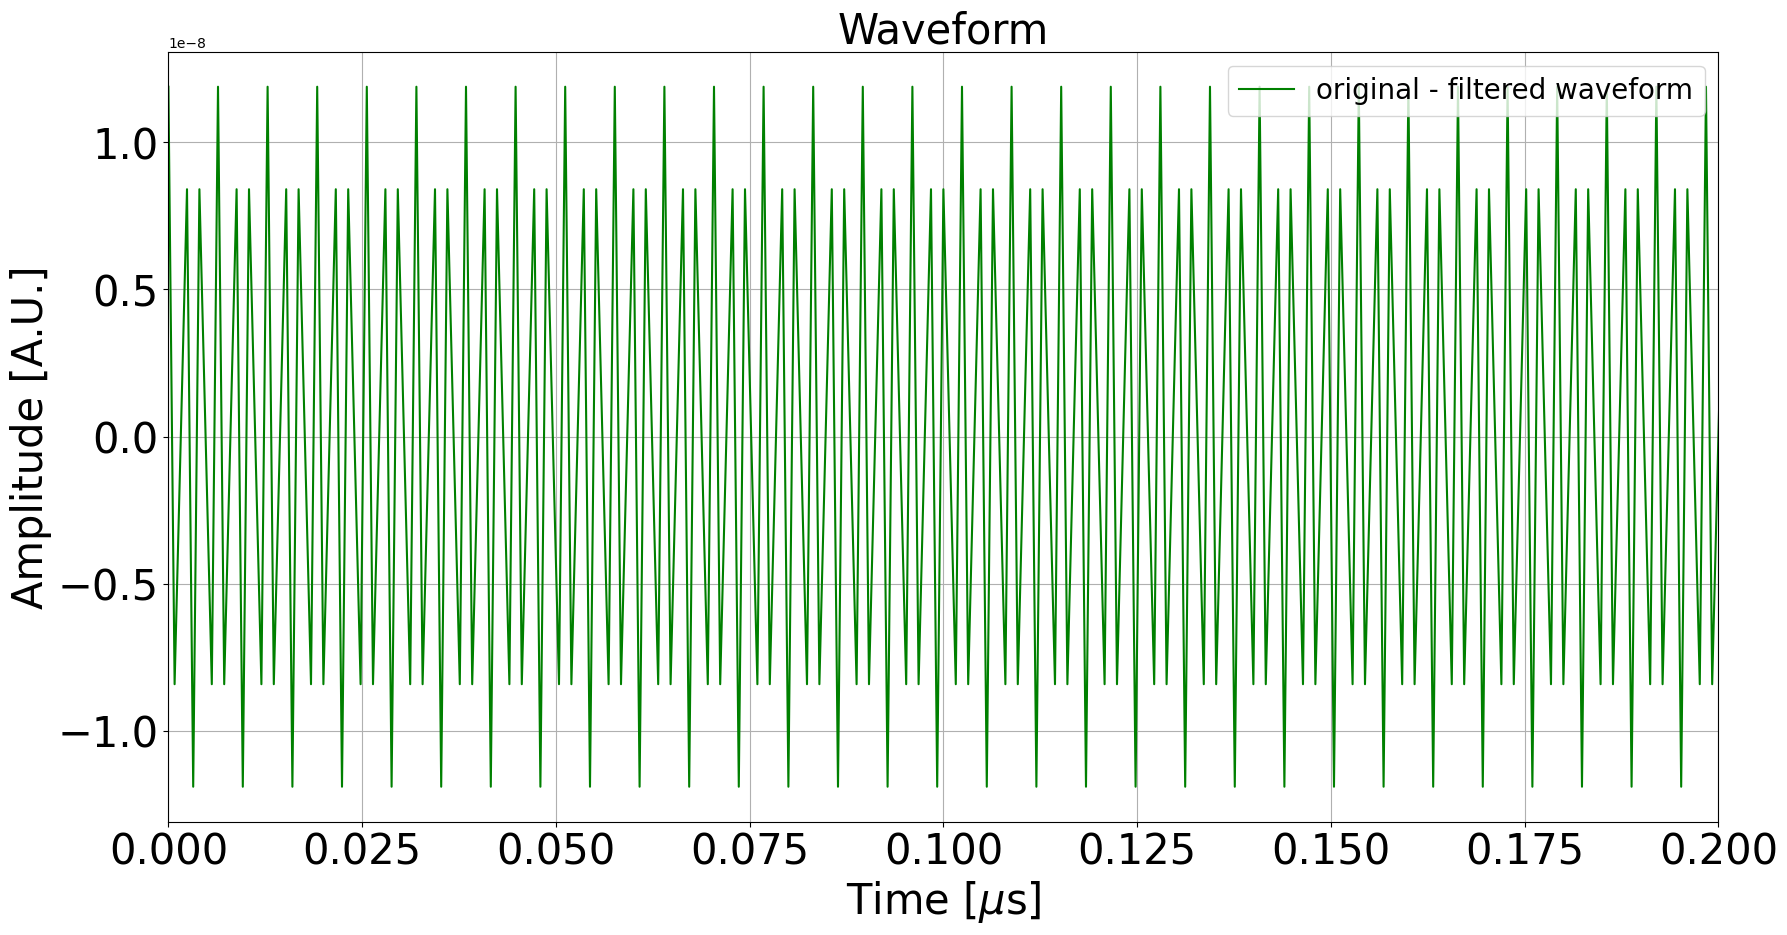

In [68]:
plt.figure(figsize = (20, 10))
plt.plot(times_ifft, original_wf - amplitudes_ifft, label = 'original - filtered waveform', color = 'green')
plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 0.2)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [13]:
#CHECK THIS WITH 2 SIMPLE WF